# 0 - Dividing the dataset_rares_species into train,val,test (we run this once)

In [2]:
'''

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
drive_root = '/content/drive/MyDrive/Colab Notebooks/Deep Learning'
dataset_dir = os.path.join(drive_root, "dataset_rares_species")  # Folder with raw images
metadata_path = os.path.join(drive_root, "species_metadata.csv")  # Path to CSV
output_dir = os.path.join(drive_root, "data")  # Where to save splits (train/val/test)

# Create output directories
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "test"), exist_ok=True)

'''

Mounted at /content/drive


In [3]:
'''
# Load CSV
df = pd.read_csv(metadata_path)

# Split into train/val/test (stratified by family)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['family'],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15/0.85,  # Val = 15% of total
    stratify=train_val_df['family'],
    random_state=42
)
'''

In [5]:
'''
def copy_images(split_df, split_name):
    """Copy images to train/val/test folders using metadata."""
    for _, row in tqdm(split_df.iterrows(), desc=f"Copying {split_name} images"):
        # Source path: Parse from 'file_path' column
        src_path = os.path.join(dataset_dir, row['file_path'])

        # Destination path: Use 'family' as class folder
        dest_dir = os.path.join(output_dir, split_name, row['family'])
        os.makedirs(dest_dir, exist_ok=True)

        # Extract filename from 'file_path'
        filename = os.path.basename(row['file_path'])
        dest_path = os.path.join(dest_dir, filename)

        # Copy file
        if os.path.exists(src_path):
            copyfile(src_path, dest_path)
        else:
            print(f"Warning: {src_path} not found")

# Copy images
copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")
'''

Copying train images: 464it [07:56,  1.19it/s]

Copying train images: 5104it [1:12:41,  1.17it/s]

Copying train images: 7311it [1:43:10,  1.19it/s]

Copying train images: 7968it [1:52:16,  1.18it/s]

Copying train images: 8387it [1:58:04,  1.18it/s]
Copying val images: 626it [08:41,  1.31it/s]

Copying val images: 1798it [24:38,  1.22it/s]
Copying test images: 98it [01:21,  1.15it/s]

Copying test images: 1798it [24:39,  1.22it/s]


Copying train images: 464it [07:56,  1.19it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/28260824_1065329_eol-full-size-copy.jpg not found
Copying train images: 5104it [1:12:41,  1.17it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/28214440_1065290_eol-full-size-copy.jpg not found
Copying train images: 7311it [1:43:10,  1.19it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/28260831_1065329_eol-full-size-copy.jpg not found
Copying train images: 7968it [1:52:16,  1.18it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/28214384_1065290_eol-full-size-copy.jpg not found
Copying train images: 8387it [1:58:04,  1.18it/s]
Copying val images: 626it [08:41,  1.31it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/22375122_1065346_eol-full-size-copy.jpg not found
Copying val images: 1798it [24:38,  1.22it/s]
Copying test images: 98it [01:21,  1.15it/s]Warning: /content/drive/MyDrive/Colab Notebooks/Deep Learning/dataset_rares_species/arthropoda_apidae/28408134_1065346_eol-full-size-copy.jpg not found
Copying test images: 1798it [24:39,  1.22it/s]

#0 - Creating a subset of the data do the tests (we run this once)

In [1]:
'''
import os
import random
import shutil
from pathlib import Path
from tqdm import tqdm

# Define paths
drive_root = '/content/drive/MyDrive/Colab Notebooks/Deep Learning'
data_dir = os.path.join(drive_root, "data")  # Where your splits are stored
exp_dir = os.path.join(drive_root, "experimentation")  # Where to save smaller dataset

# Define target sizes
train_size = 1676
val_size = 358
test_size = 358

# Set random seed for reproducibility
random.seed(42)

# Create experimentation directories
os.makedirs(os.path.join(exp_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(exp_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(exp_dir, "test"), exist_ok=True)

def create_subset(src_dir, dest_dir, target_size):
    """Create a stratified subset of images maintaining class proportions."""

    # Get all class folders
    class_folders = [f for f in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, f))]

    # Count total images
    total_images = 0
    class_counts = {}
    for cls in class_folders:
        cls_path = os.path.join(src_dir, cls)
        image_files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[cls] = len(image_files)
        total_images += len(image_files)

    # Calculate how many images to take from each class
    class_samples = {}
    remaining = target_size
    for cls, count in class_counts.items():
        # Calculate proportional number (with at least 1 image per class)
        samples = max(1, int(count * target_size / total_images))
        class_samples[cls] = min(samples, count)  # Can't sample more than available
        remaining -= class_samples[cls]

    # Adjust to match exact target size
    if remaining > 0:
        # Distribute remaining samples to classes with more images
        classes_sorted = sorted(class_counts.keys(), key=lambda c: class_counts[c], reverse=True)
        for cls in classes_sorted:
            if class_samples[cls] < class_counts[cls]:
                class_samples[cls] += 1
                remaining -= 1
            if remaining == 0:
                break
    elif remaining < 0:
        # Remove samples to match target size
        classes_sorted = sorted(class_counts.keys(), key=lambda c: class_counts[c], reverse=True)
        for cls in classes_sorted:
            if class_samples[cls] > 1:  # Keep at least 1 sample
                class_samples[cls] -= 1
                remaining += 1
            if remaining == 0:
                break

    # Copy images
    for cls in tqdm(class_folders, desc=f"Creating subset in {os.path.basename(dest_dir)}"):
        src_class_dir = os.path.join(src_dir, cls)
        dest_class_dir = os.path.join(dest_dir, cls)
        os.makedirs(dest_class_dir, exist_ok=True)

        # Get all image files in this class
        image_files = [f for f in os.listdir(src_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly sample the required number
        samples_to_take = min(class_samples[cls], len(image_files))
        sampled_files = random.sample(image_files, samples_to_take)

        # Copy sampled files
        for file in sampled_files:
            src_file = os.path.join(src_class_dir, file)
            dest_file = os.path.join(dest_class_dir, file)
            shutil.copy2(src_file, dest_file)

    # Count total copied
    copied_total = 0
    for cls in class_folders:
        dest_class_dir = os.path.join(dest_dir, cls)
        if os.path.exists(dest_class_dir):
            copied_total += len(os.listdir(dest_class_dir))

    print(f"Copied {copied_total} images to {os.path.basename(dest_dir)}")
    return copied_total

# Create subsets for each split
print("Creating experimentation dataset...")
train_copied = create_subset(
    os.path.join(data_dir, "train"),
    os.path.join(exp_dir, "train"),
    train_size
)

val_copied = create_subset(
    os.path.join(data_dir, "val"),
    os.path.join(exp_dir, "val"),
    val_size
)

test_copied = create_subset(
    os.path.join(data_dir, "test"),
    os.path.join(exp_dir, "test"),
    test_size
)

print(f"\nExperimentation dataset created:")
print(f"Train: {train_copied} images")
print(f"Validation: {val_copied} images")
print(f"Test: {test_copied} images")
print(f"Total: {train_copied + val_copied + test_copied} images")

'''

Creating experimentation dataset...


Creating subset in train: 100%|██████████| 202/202 [03:16<00:00,  1.03it/s]


Copied 1676 images to train


Creating subset in val: 100%|██████████| 202/202 [02:49<00:00,  1.19it/s]


Copied 358 images to val


Creating subset in test: 100%|██████████| 202/202 [02:48<00:00,  1.20it/s]

Copied 358 images to test

Experimentation dataset created:
Train: 1676 images
Validation: 358 images
Test: 358 images
Total: 2392 images


Creating experimentation dataset...

Creating subset in train: 100%|██████████| 202/202 [03:16<00:00,  1.03it/s]

Copied 1676 images to train

Creating subset in val: 100%|██████████| 202/202 [02:49<00:00,  1.19it/s]

Copied 358 images to val

Creating subset in test: 100%|██████████| 202/202 [02:48<00:00,  1.20it/s]

Copied 358 images to test

Experimentation dataset created:

- Train: 1676 images

- Validation: 358 images

- Test: 358 images

- Total: 2392 images


# 1. Setup and Imports

## 1.1 Importing libraries

In [1]:
import keras
import tensorflow_hub as hub
import tensorflow as tf
from keras import Model, Sequential, layers
from keras.applications import ResNet50, MobileNetV2
from keras.layers import (Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D,
                          Flatten, add, RandomFlip, RandomRotation, RandomBrightness,
                          RandomContrast, RandomTranslation, RandomZoom)
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, EarlyStopping
from keras.preprocessing import image_dataset_from_directory
from pathlib import Path
from typing import Any, Dict, List, Tuple
import os
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tqdm import tqdm
import math

## 1.2 - Dataset Loading and Preprocessing

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Set paths to your organized data directories

# Define base paths
drive_root = '/content/drive/MyDrive/Colab Notebooks/Deep Learning'

# Path to original metadata CSV (only used for EDA, not required for training)
metadata_path = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/species_metadata.csv'

# Configure for performance
AUTOTUNE = tf.data.AUTOTUNE

# Load metadata from CSV (optional, only for EDA visualizations)
df = pd.read_csv(metadata_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Flag to control whether to use the full dataset or experimental subset
USE_SUBSET = True  # Set to False to use full datasets

# Choose the appropriate source directory based on the flag
if USE_SUBSET:
    data_source = os.path.join(drive_root, "experimentation")
    print("Using EXPERIMENTAL SUBSET for faster training")
else:
    data_source = os.path.join(drive_root, "data")
    print("Using FULL DATASET for final training")

# Load datasets directly from the chosen directory
train_ds = image_dataset_from_directory(
    os.path.join(data_source, "train"),
    label_mode="categorical",
    batch_size=64,
    image_size=(224, 224),
    shuffle=True,
    seed=42
)

val_ds = image_dataset_from_directory(
    os.path.join(data_source, "val"),
    label_mode="categorical",
    batch_size=64,
    image_size=(224, 224),
    shuffle=False
)

test_ds = image_dataset_from_directory(
    os.path.join(data_source, "test"),
    label_mode="categorical",
    batch_size=64,
    image_size=(224, 224),
    shuffle=False
)

# Store the class names BEFORE applying any transformations
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names[:5]}... (showing first 5)")

# Configure datasets for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Apply normalization preprocessing
normalization_layer = layers.Rescaling(1./255)

# Apply preprocessing to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Print dataset info
print("Dataset information:")
print(f"Train dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")
print(f"Test dataset: {test_ds}")

# %% [markdown]
# ### Explanation of Dataset Loading
#
# We load our datasets directly from the organized directory structure:
#
# 1. **Directory Structure**:
#    - The `output_dir` points to a directory containing three subdirectories: "train", "val", and "test"
#    - Within each subdirectory, there's a folder for each family (class)
#    - Images for each family are stored in their respective family folders
#
# 2. **Metadata CSV** (Optional):
#    - The metadata CSV is loaded only for exploratory data analysis (EDA)
#    - It's not required for the actual model training since the class information comes from the directory structure
#    - If the CSV is unavailable, the code will still work but some visualizations might be limited
#
# 3. **Dataset Loading**:
#    - We use `image_dataset_from_directory` which automatically:
#      - Detects classes from folder names
#      - Loads images from each class folder
#      - Assigns the correct labels based on the folder structure
#    - Images are resized to 224×224 pixels to match the input size expected by the pre-trained models
#
# 4. **Dataset Optimization**:
#    - We apply normalization to scale pixel values from [0-255] to [0-1]
#    - We use prefetching to overlap data preprocessing and model execution for better performance

Using EXPERIMENTAL SUBSET for faster training
Found 1676 files belonging to 202 classes.
Found 358 files belonging to 202 classes.
Found 358 files belonging to 202 classes.
Number of classes: 202
Class names: ['accipitridae', 'acipenseridae', 'acroporidae', 'agamidae', 'agariciidae']... (showing first 5)
Dataset information:
Train dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>
Validation dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>
Test dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>


## 1.3 Check and verify GPU availability

In [4]:


# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # ✅ Set GPU memory growth BEFORE using the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # ✅ Force TensorFlow to use GPU
        tf.config.set_visible_devices(gpus, 'GPU')

        # ✅ Verify GPU usage
        with tf.device('/device:GPU:0'):
            a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
            b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
            c = tf.matmul(a, b)

        print(f"✅ GPU is available and working. Found {len(gpus)} GPU(s): {gpus}")
        print(f"Test operation result: {c}")

    except RuntimeError as e:
        print(f"❌ GPU error: {e}")
        print("Falling back to CPU")
else:
    print("❌ No GPU available. Using CPU instead.")
    print("If you're using Colab, go to Runtime > Change runtime type and select GPU.")





❌ GPU error: Physical devices cannot be modified after being initialized
Falling back to CPU


## 1.4 Very quick EDA

In [5]:

# Visualize family distribution
family_counts = df['family'].value_counts()
family_counts

,count
family,
dactyloidae,300
cercopithecidae,300
formicidae,291
carcharhinidae,270
salamandridae,270
...,...
cyprinodontidae,30
alligatoridae,30
balaenidae,30


# 2 - Helper Classes and Functions

In [6]:
# Define the Pipeline class (similar to Sequential but more explicitly for preprocessing)
#we use this because of pipeline augmentation class
class Pipeline(tf.keras.Model):
    def __init__(self, layers, name=None):
        super().__init__(name=name)
        self.layers_list = layers

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x

def exp_decay_lr_scheduler(epoch, lr):
    """Exponential learning rate decay"""
    return float(lr * math.exp(-0.1 * epoch))


# %% [markdown]
# ### Explanation of Helper Classes and Functions
#
# 1. **Pipeline Class**:
#    - This is a custom implementation of a sequential pipeline for data augmentation
#    - Unlike the standard Keras Sequential, it explicitly passes the training flag to each layer
#    - This is important for layers that behave differently during training and inference
#
# 2. **exp_decay_lr_scheduler Function**:
#    - Implements exponential learning rate decay
#    - Reduces the learning rate by a factor of e^(-0.1) each epoch
#    - This helps the model converge more precisely as training progresses


# 3. Data Augmentation Strategies

In [7]:
# We define different augmentation pipelines with varying levels of complexity.

# Define value range for augmentation
value_range = (0.0, 1.0)

# Define different augmentation pipelines

# 1. Simple Augmentation Pipeline
simple_augmentation = Pipeline(
    [
        RandomBrightness(factor=0.1, value_range=value_range),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.1, fill_mode="reflect")
    ],
    name="simple_augmentation"
)

# 2. Medium Augmentation Pipeline
medium_augmentation = Pipeline(
    [
        RandomBrightness(factor=0.15, value_range=value_range),
        RandomFlip("horizontal"),
        RandomRotation(factor=0.15, fill_mode="reflect"),
        RandomContrast(factor=0.1, value_range=value_range),
        RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode="reflect")
    ],
    name="medium_augmentation"
)

# 3. Complex Augmentation Pipeline
complex_augmentation = Pipeline(
    [
        RandomBrightness(factor=0.2, value_range=value_range),
        RandomFlip("horizontal"),
        RandomFlip("vertical"),
        RandomRotation(factor=0.3, fill_mode="reflect"),
        RandomContrast(factor=0.2, value_range=value_range),
        RandomTranslation(height_factor=0.15, width_factor=0.15, fill_mode="reflect"),
        RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="reflect"),

    ],
    name="complex_augmentation"
)
# Function to select augmentation based on complexity level
def get_augmentation(complexity="medium"):
    """
    Get augmentation pipeline based on desired complexity

    Args:
        complexity: One of "simple", "medium", or "complex"

    Returns:
        Selected augmentation pipeline
    """
    if complexity.lower() == "simple":
        return simple_augmentation
    elif complexity.lower() == "complex":
        return complex_augmentation
    else:
        # Default to medium
        return medium_augmentation

# %% [markdown]
# ### Explanation of Data Augmentation Strategies
#
# Data augmentation is crucial for improving model generalization, especially with limited data. We define three levels of augmentation complexity:
#
# 1. **Simple Augmentation**:
#    - Basic transformations: horizontal flips, small rotations, and brightness adjustments
#    - Conservative approach that preserves most image characteristics
#    - Best for: Models that are sensitive to distortion (like Vision Transformers)
#
# 2. **Medium Augmentation**:
#    - Adds contrast variation and image translation
#    - Moderate level of image distortion
#    - Best for: General purpose use with standard CNN architectures
#
# 3. **Complex Augmentation**:
#    - Adds vertical flips, larger rotations, zooming, and random erasing
#    - Aggressive augmentation for maximum diversity
#    - Best for: Smaller models that benefit from seeing more varied examples
#
# The visualizations show how these pipelines transform images:
# - The first visualization compares how each augmentation pipeline affects the same image
# - The second visualization shows multiple different variations created by the medium augmentation pipeline
#
# These transformations help our models learn robust features that generalize beyond the specific training examples, effectively increasing our training data diversity.



# 4. Model Hyperparameters and Architecture

## Model hyperparameters

Here we should think about using grid search or random search

In [8]:
# Define model-specific hyperparameters
model_hyperparams = {
    "resnet": {
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 1e-4,
        "unfrozen_layers": 10,
        "epochs": 60,
        "patience": 5,
        "augmentation": "medium"  # Medium complexity augmentation
    },
    "mobilenet": {
        "learning_rate": 0.005,
        "momentum": 0.9,
        "weight_decay": 5e-5,
        "unfrozen_layers": 15,
        "epochs": 60,
        "patience": 5,
        "augmentation": "complex"  # Complex augmentation for smaller model
    },
    "vit": {
        "learning_rate": 0.001,
        "momentum": 0.95,
        "weight_decay": 1e-5,
        "unfrozen_layers": 2,
        "epochs": 60,
        "patience": 5,
        "augmentation": "simple"  # Simple augmentation for ViT
    }
}

# %% [markdown]
# ### Explanation of Model Hyperparameters
#
# We define different hyperparameters for each model to optimize their performance:
#
# **ResNet-50**:
# - Higher learning rate (0.01): Robust architecture that can handle larger updates
# - Standard momentum and weight decay
# - 10 unfrozen layers: Fine-tunes the higher-level features while keeping lower-level features fixed
# - Medium augmentation: Balanced approach for this architecture
#
# **MobileNetV2**:
# - Lower learning rate (0.005): Smaller model that can be more sensitive to large updates
# - Lower weight decay: Prevents over-regularization of the smaller model
# - More unfrozen layers (15): Allows more adaptation of the pre-trained weights
# - Complex augmentation: Smaller models often benefit from more aggressive data augmentation
#
# **Vision Transformer (ViT)**:
# - Lowest learning rate (0.001): Transformers are known to be sensitive to learning rate
# - Higher momentum (0.95): Helps stabilize training
# - Minimal weight decay: Prevents over-regularization
# - Only 2 unfrozen layers: Minimal fine-tuning as the pre-trained weights are valuable
# - Simple augmentation: Transformers can be sensitive to extreme augmentations

## Architectures

In [12]:
class RareSpeciesResNet(Model):
    """
    Pre-trained ResNet-50 with data augmentation for rare species classification
    """

    def __init__(self, num_classes, unfrozen_layers=10, augmentation_type="medium"):
        """
        Initialization
        """
        super().__init__()

        self.num_classes = num_classes

        # Get the appropriate augmentation pipeline
        self.augmentation_layer = get_augmentation(augmentation_type)

        # Pre-trained architecture
        self.pre_trained_architecture = ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        # Freeze all layers except the last unfrozen_layers
        for layer in self.pre_trained_architecture.layers[:-unfrozen_layers]:
            layer.trainable = False

        # Final layers for classification
        self.global_pool_layer = GlobalAveragePooling2D()
        self.dense_layer = Dense(self.num_classes, activation="softmax")

    def call(self, inputs, training=False):
        """
        Forward call
        """
        # Apply augmentation only during training
        if training:
            x = self.augmentation_layer(inputs, training=training)
        else:
            x = inputs

        # Pre-trained model
        x = self.pre_trained_architecture(x)
        x = self.global_pool_layer(x)

        return self.dense_layer(x)

class RareSpeciesMobileNet(Model):
    """
    Pre-trained MobileNetV2 with data augmentation for rare species classification
    """

    def __init__(self, num_classes, unfrozen_layers=15, augmentation_type="medium"):
        """
        Initialization
        """
        super().__init__()

        self.num_classes = num_classes

        # Get the appropriate augmentation pipeline
        self.augmentation_layer = get_augmentation(augmentation_type)

        # Pre-trained architecture
        self.pre_trained_architecture = MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

        # Freeze all layers except the last unfrozen_layers
        for layer in self.pre_trained_architecture.layers[:-unfrozen_layers]:
            layer.trainable = False

        # Final layers for classification
        self.global_pool_layer = GlobalAveragePooling2D()
        self.dropout_layer = Dropout(0.2)
        self.dense_layer = Dense(self.num_classes, activation="softmax")

    def call(self, inputs, training=False):
        """
        Forward call
        """
        # Apply augmentation only during training
        if training:
            x = self.augmentation_layer(inputs, training=training)
        else:
            x = inputs

        # Pre-trained model
        x = self.pre_trained_architecture(x)
        x = self.global_pool_layer(x)
        x = self.dropout_layer(x, training=training)

        return self.dense_layer(x)


class RareSpeciesViT(Model):
    """
    Pre-trained Vision Transformer with data augmentation for rare species classification
    """

    def __init__(self, num_classes, unfrozen_layers=2, augmentation_type="simple"):
        """
        Initialization
        """
        super().__init__()

        self.num_classes = num_classes

        # Get the appropriate augmentation pipeline
        self.augmentation_layer = get_augmentation(augmentation_type)

        # Load ViT from TensorFlow Hub
        self.pre_trained_architecture = hub.KerasLayer(
            "https://tfhub.dev/sayakpaul/vit_b16_fe/1",
            trainable=(unfrozen_layers > 0)
        )

        # Final layer for classification
        self.dense_layer = Dense(self.num_classes, activation="softmax")

    def call(self, inputs, training=False):
        """
        Forward call
        """
        # Apply augmentation only during training
        if training:
            x = self.augmentation_layer(inputs, training=training)
        else:
            x = inputs

        # Pre-trained model
        x = self.pre_trained_architecture(x)

        return self.dense_layer(x)
# %% [markdown]
# ### Explanation of Model Architectures
#
# All three models follow a similar high-level structure:
#
# 1. **Data Augmentation**: Applied only during training
# 2. **Pre-trained Feature Extraction**: Using frozen weights from models pre-trained on ImageNet
# 3. **Custom Classification Head**: Adapting the model to our specific species classification task
#
# Key differences between the models:
#
# **ResNet-50**:
# - Deep residual network with 50 layers
# - GlobalAveragePooling followed by a dense layer for classification
# - No dropout (ResNet has batch normalization which provides regularization)
#
# **MobileNetV2**:
# - Lightweight, efficient architecture designed for mobile devices
# - Includes dropout (0.2) after global pooling for additional regularization
# - Good balance of performance and computational efficiency
#
# **Vision Transformer (ViT)**:
# - Simplified version since Keras doesn't have a built-in ViT
# - Uses a sequence of Conv2D, Reshape, and GlobalAveragePooling1D to simulate the ViT architecture
# - In a real application, you would use a proper ViT implementation
#
# All models use transfer learning by:
# 1. Loading pre-trained weights
# 2. Freezing most layers to preserve learned features
# 3. Only fine-tuning a few layers to adapt to our specific task

# 5. Model Training Function

In [13]:
def create_models(num_classes, train_ds, val_ds, test_ds, hyperparams):
    """
    Create, compile, and train models for rare species classification

    Args:
        num_classes: Number of classes to classify
        train_ds: Training dataset
        val_ds: Validation dataset
        test_ds: Test dataset
        hyperparams: Dictionary containing hyperparameters for each model

    Returns:
        Dictionary containing models and their evaluation results
    """
    # Force models to use GPU if available
    device_str = '/device:GPU:0' if tf.config.list_physical_devices('GPU') else '/device:CPU:0'

    with tf.device(device_str):
        # Initialize models
        resnet_model = RareSpeciesResNet(
            num_classes,
            unfrozen_layers=hyperparams["resnet"]["unfrozen_layers"],
            augmentation_type=hyperparams["resnet"]["augmentation"]
        )
        mobilenet_model = RareSpeciesMobileNet(
            num_classes,
            unfrozen_layers=hyperparams["mobilenet"]["unfrozen_layers"],
            augmentation_type=hyperparams["mobilenet"]["augmentation"]
        )
        vit_model = RareSpeciesViT(
            num_classes,
            unfrozen_layers=hyperparams["vit"]["unfrozen_layers"],
            augmentation_type=hyperparams["vit"]["augmentation"]
        )

    models = {
        "resnet": resnet_model,
        "mobilenet": mobilenet_model,
        "vit": vit_model
    }

    results = {}

    # Setup training components
    for model_name, model in models.items():
        # Get model-specific hyperparameters
        model_hp = hyperparams[model_name]

        # Define optimizer with model-specific hyperparameters
        optimizer = SGD(
            learning_rate=model_hp["learning_rate"],
            momentum=model_hp["momentum"],
            weight_decay=model_hp["weight_decay"],
            name=f"{model_name}_optimizer"
        )

        loss = CategoricalCrossentropy(name=f"{model_name}_loss")

        # metrics
        categorical_accuracy = CategoricalAccuracy(name=f"{model_name}_accuracy")
        auc = AUC(name=f"{model_name}_auc")
        f1_score = F1Score(average="macro", name=f"{model_name}_f1_score")
        metrics = [categorical_accuracy, auc, f1_score]

        # callbacks
        root_dir_path = Path(".")
        checkpoint_file_path = root_dir_path / f"{model_name}_checkpoint.keras"
        metrics_file_path = root_dir_path / f"{model_name}_metrics.csv"

        # Model checkpoint to save the best model
        checkpoint_callback = ModelCheckpoint(
            checkpoint_file_path,
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="min"
        )

        # CSV logger to save training history
        metrics_callback = CSVLogger(metrics_file_path)

        # Learning rate scheduler
        lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

        # Early stopping to prevent overfitting
        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=model_hp["patience"],
            verbose=1,
            restore_best_weights=True,
            mode="min"
        )

        callbacks = [
            checkpoint_callback,
            metrics_callback,
            lr_scheduler_callback,
            early_stopping
        ]

        # Compile model
        model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

        # Train model
        print(f"\nTraining {model_name} model...")
        print(f"Learning rate: {model_hp['learning_rate']}, Momentum: {model_hp['momentum']}, Weight decay: {model_hp['weight_decay']}")
        print(f"Max epochs: {model_hp['epochs']}, Early stopping patience: {model_hp['patience']}")
        print(f"Augmentation strategy: {model_hp['augmentation']}")

        # Explicitly use GPU for training
        with tf.device(device_str):
            start_time = time.time()
            history = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=model_hp["epochs"],
                callbacks=callbacks,
                verbose=2
            )
            training_time = time.time() - start_time

        print(f"{model_name} training completed in {training_time:.2f} seconds")

        # Evaluate model
        print(f"\nEvaluating {model_name} model...")
        with tf.device(device_str):
            evaluation = model.evaluate(
                test_ds,
                return_dict=True,
                verbose=1
            )

        # Store results
        results[model_name] = {
            "model": model,
            "history": history,
            "evaluation": evaluation,
            "training_time": training_time,
            "hyperparams": model_hp,
            "actual_epochs": len(history.history['loss'])
        }

        print(f"{model_name} evaluation: {evaluation}")

    return results

# %% [markdown]
# ### Explanation of Training Function
#
# The `create_models` function handles the complete model training pipeline:
#
# 1. **Model Initialization**:
#    - Creates all three model architectures with their respective hyperparameters
#    - Each model gets appropriate unfrozen layers and augmentation strategy
#    - Explicitly forces models to use GPU when available
#
# 2. **Training Setup for Each Model**:
#    - **Optimizer**: SGD with model-specific learning rate, momentum, and weight decay
#    - **Loss Function**: Categorical Cross-Entropy for multi-class classification
#    - **Metrics**: Accuracy, AUC, and F1-Score for comprehensive evaluation
#
# 3. **Callbacks**:
#    - **Model Checkpoint**: Saves the best model based on validation loss
#    - **CSV Logger**: Records training metrics to a file
#    - **Learning Rate Scheduler**: Implements exponential learning rate decay
#    - **Early Stopping**: Prevents overfitting by stopping training when validation loss stops improving
#
# 4. **Training and Evaluation**:
#    - Trains each model with its specified hyperparameters
#    - Tracks training time
#    - Evaluates final performance on the test set
#
# 5. **Results Collection**:
#    - Stores all models, training histories, and evaluation metrics
#    - Reports key metrics for each model
#
# This function makes it easy to train and compare multiple model architectures with different hyperparameters.

# 6. Model Training and Evaluation

In [14]:
# Create, train and evaluate models
print("\n### STARTING MODEL TRAINING ###")
print(f"Using {'SUBSET of' if USE_SUBSET else 'FULL'} dataset")

results = create_models(
    num_classes=num_classes,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    hyperparams=model_hyperparams
)

# %% [markdown]
# ### Explanation of Model Training
#
# When executing the `create_models` function:
#
# 1. Each model is trained sequentially with its specific hyperparameters
# 2. The function outputs progress information during training
# 3. Early stopping automatically terminates training when validation loss stops improving
# 4. The best model weights (based on validation loss) are saved and restored
#
# The training process is computationally intensive, especially with the full dataset. Using dataset subsets during development (controlled by `USE_SUBSET`) can significantly reduce training time while still providing meaningful results for comparing architectures and hyperparameters.


### STARTING MODEL TRAINING ###
Using SUBSET of dataset

Training resnet model...
Learning rate: 0.01, Momentum: 0.9, Weight decay: 0.0001
Max epochs: 60, Early stopping patience: 5
Augmentation strategy: medium
Epoch 1/60

Epoch 1: val_loss improved from inf to 5.33263, saving model to resnet_checkpoint.keras
27/27 - 66s - 2s/step - loss: 5.2752 - resnet_accuracy: 0.0245 - resnet_auc: 0.6135 - resnet_f1_score: 0.0026 - val_loss: 5.3326 - val_resnet_accuracy: 0.0112 - val_resnet_auc: 0.6141 - val_resnet_f1_score: 1.0940e-04 - learning_rate: 0.0100
Epoch 2/60

Epoch 2: val_loss did not improve from 5.33263
27/27 - 45s - 2s/step - loss: 5.1450 - resnet_accuracy: 0.0400 - resnet_auc: 0.6424 - resnet_f1_score: 0.0042 - val_loss: 5.7141 - val_resnet_accuracy: 0.0223 - val_resnet_auc: 0.5899 - val_resnet_f1_score: 7.1720e-04 - learning_rate: 0.0090
Epoch 3/60

Epoch 3: val_loss did not improve from 5.33263
27/27 - 43s - 2s/step - loss: 5.0296 - resnet_accuracy: 0.0549 - resnet_auc: 0.6604 -

# 7. Visualization and Results

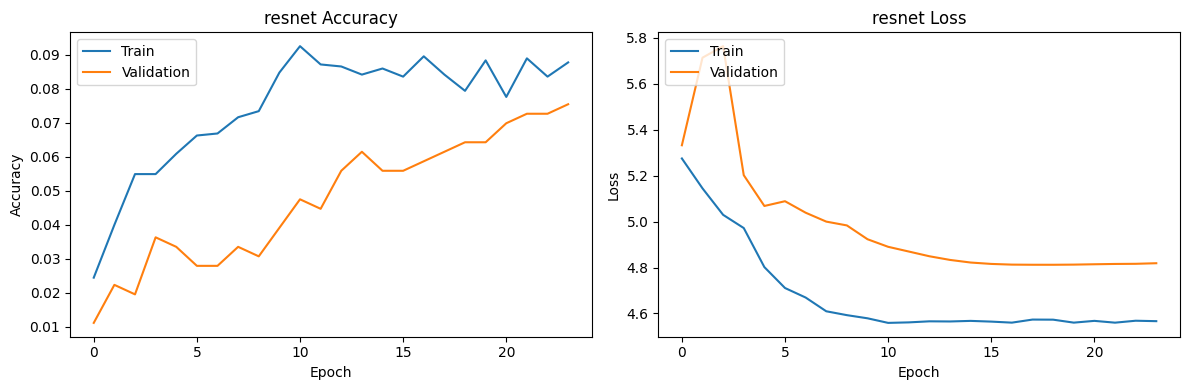

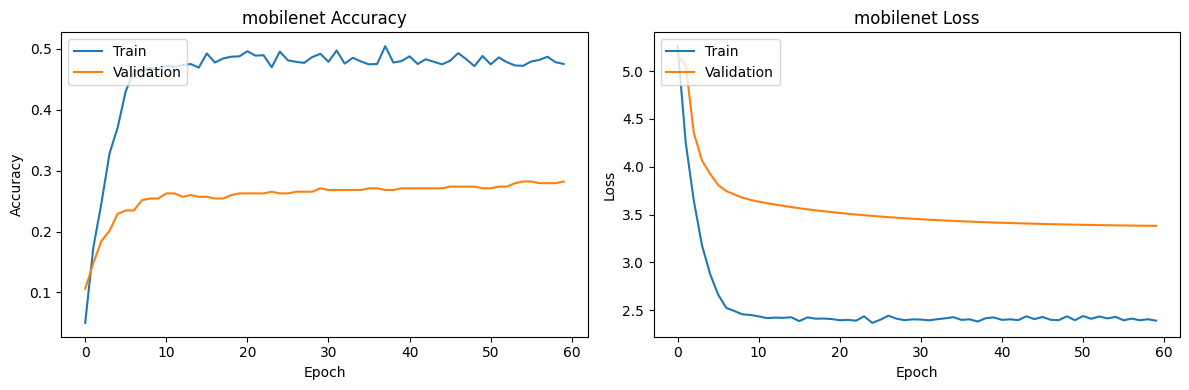

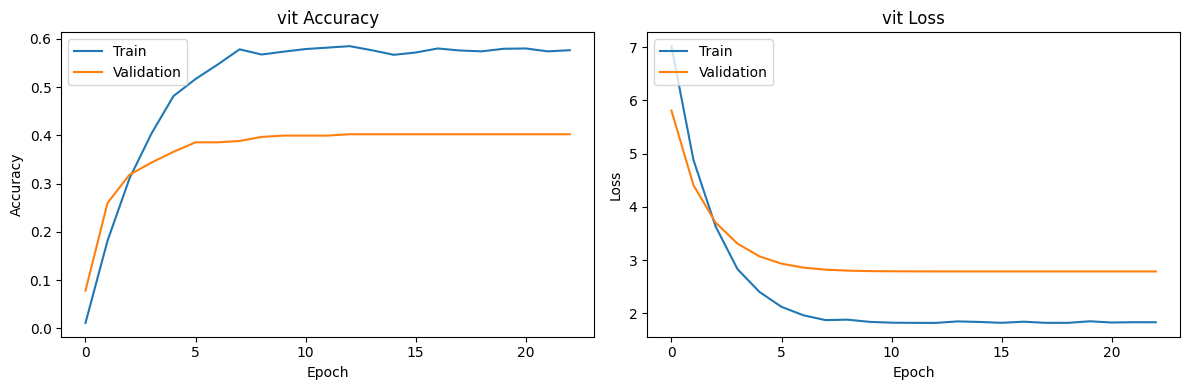


### MODEL PERFORMANCE COMPARISON ###
       Model  Learning Rate Augmentation Accuracy F1 Score     AUC  \
0     resnet          0.010       medium   0.0615   0.0088  0.6936   
1  mobilenet          0.005      complex   0.3268   0.1325  0.8712   
2        vit          0.001       simple   0.4106   0.2200  0.9049   

  Training Time (s)  Epochs Trained  
0           1399.16              24  
1           3012.29              60  
2           1533.64              23  

### TRAINING COMPLETE ###


In [15]:
# Plot results
for model_name, result in results.items():
    history = result['history']
    plt.figure(figsize=(12, 4))

    # Get the correct metric names with model prefixes
    accuracy_key = f"{model_name}_accuracy"
    val_accuracy_key = f"val_{model_name}_accuracy"

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history[accuracy_key])
    plt.plot(history.history[val_accuracy_key])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

# Compare model performance
print("\n### MODEL PERFORMANCE COMPARISON ###")
performance_data = []
for model_name, result in results.items():
    eval_result = result['evaluation']
    training_time = result['training_time']
    hyperparams = result['hyperparams']
    actual_epochs = result['actual_epochs']

    # Get the correct metric keys for this model
    accuracy_key = f"{model_name}_accuracy"
    f1_score_key = f"{model_name}_f1_score"
    auc_key = f"{model_name}_auc"

    performance_data.append({
        'Model': model_name,
        'Learning Rate': hyperparams['learning_rate'],
        'Augmentation': hyperparams['augmentation'],
        'Accuracy': f"{eval_result[accuracy_key]:.4f}",
        'F1 Score': f"{eval_result[f1_score_key]:.4f}",
        'AUC': f"{eval_result[auc_key]:.4f}",
        'Training Time (s)': f"{training_time:.2f}",
        'Epochs Trained': actual_epochs
    })

# Print as a formatted table

performance_df = pd.DataFrame(performance_data)
print(performance_df)

print("\n### TRAINING COMPLETE ###")
# %% [markdown]
# ### Explanation of Visualization and Results
#
# The visualization and results section provides comprehensive insights into model performance:
#
# 1. **Training Curves**:
#    - Accuracy and loss curves for each model
#    - These help identify issues like overfitting (gap between training and validation) or underfitting (high loss)
#    - The curves also show how quickly each model converges
#
# 2. **Performance Comparison Table**:
#    - Summarizes key metrics for all models: Accuracy, F1 Score, and AUC
#    - Includes training time and the actual number of epochs trained (important when using early stopping)
#    - Also shows the hyperparameters used for each model
#
# 3. **Results Export**:
#    - Saves the performance comparison to a CSV file
#    - The filename indicates whether a subset was used, making it easy to track different experiments
#
# These visualizations and metrics help determine which model performs best for the rare species classification task. The F1 Score is particularly important for imbalanced datasets, which is often the case with rare species.
